In [15]:
import pandas as pd
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# 读取数据
data = pd.read_csv('diabetes_prediction_dataset_2000_samples_2025.csv')
X = data.drop(['PersonID', 'Diabetes_2025'], axis=1)
#data中删除PersonID和Diabetes_2025两列，将剩下的列作为特征数据，存储在X变量中。这里假设PersonID是一个标识列，不参与模型训练，Diabetes_2025是目标变量。
y = data['Diabetes_2025']

In [17]:
# 数据集划分 (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 特征标准化（仅对X处理）
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_valid = scaler_X.transform(X_valid)
X_test = scaler_X.transform(X_test)

# 转换为张量（分类任务，y用long类型）
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [21]:
# 定义DNN分类器模型
class DNNClassifier(nn.Module):
    def __init__(self, hidden1, hidden2, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(61, hidden1),  # 输入维度为8（特征数）
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 2)   # 输出维度为2（二分类）
        )

    def forward(self, x):
        return self.net(x)

In [22]:
# 定义Optuna目标函数
def objective(trial):
    # 超参数采样
    hidden1 = trial.suggest_int("hidden1", 32, 128)
    hidden2 = trial.suggest_int("hidden2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # 构建模型、损失函数、优化器
    model = DNNClassifier(hidden1=hidden1, hidden2=hidden2, dropout=dropout)
    criterion = nn.CrossEntropyLoss()  # 分类任务用交叉熵损失
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # 构建数据加载器（按批次训练）
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 训练模型并记录损失
    train_losses = []
    val_losses = []
    for epoch in range(100):  # 训练100轮
        # 训练阶段
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:  # 按批次处理
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * xb.size(0)  # 累计损失
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)  # 平均损失
        train_losses.append(avg_train_loss)

         # 验证阶段
        model.eval()
        with torch.no_grad():
            val_pred = model(X_valid_tensor)
            val_loss = criterion(val_pred, y_valid_tensor).item()
            val_losses.append(val_loss)

        # 每10轮打印一次（可选）
        if (epoch + 1) % 10 == 0:
            trial.report(val_loss, epoch)  # 向Optuna报告中间结果

        # 计算最终验证集准确率（作为优化指标）
        model.eval()
        with torch.no_grad():
            val_pred = model(X_valid_tensor)
            _, predicted = torch.max(val_pred, 1)
        accuracy = accuracy_score(y_valid, predicted.numpy())

        return accuracy  # 返回验证集准确率，Optuna最大化此值

In [23]:
# 运行Optuna超参数优化
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # 20次试验

# 输出最优超参数
print("最佳试验结果:")
best_trial = study.best_trial
print(f"  验证集准确率: {best_trial.value:.4f}")
print("  最优超参数:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-05 11:34:00,970] A new study created in memory with name: no-name-4a61b58b-1ef9-46d3-a878-c0ee657ae255
[I 2025-08-05 11:34:01,109] Trial 0 finished with value: 0.7025 and parameters: {'hidden1': 87, 'hidden2': 25, 'dropout': 0.10679369856533666, 'lr': 0.003178457051777441, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7025.
[I 2025-08-05 11:34:01,266] Trial 1 finished with value: 0.7025 and parameters: {'hidden1': 119, 'hidden2': 59, 'dropout': 0.19897497251477048, 'lr': 0.00012975523192229377, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7025.
[I 2025-08-05 11:34:01,381] Trial 2 finished with value: 0.7025 and parameters: {'hidden1': 35, 'hidden2': 29, 'dropout': 0.2648409858882968, 'lr': 0.0001621117606647719, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7025.
[I 2025-08-05 11:34:01,476] Trial 3 finished with value: 0.53 and parameters: {'hidden1': 69, 'hidden2': 57, 'dropout': 0.3426076823859483, 'l

最佳试验结果:
  验证集准确率: 0.7025
  最优超参数:
    hidden1: 87
    hidden2: 25
    dropout: 0.10679369856533666
    lr: 0.003178457051777441
    batch_size: 64
    optimizer: Adam


In [24]:
# 用最优超参数训练最终模型并记录损失
best_params = best_trial.params
model_final = DNNClassifier(
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout=best_params["dropout"]
)
criterion = nn.CrossEntropyLoss()  # 分类任务用交叉熵
optimizer_cls = getattr(optim, best_params["optimizer"])
optimizer = optimizer_cls(model_final.parameters(), lr=best_params["lr"])

In [25]:
# 合并训练集+验证集进行最终训练
X_train_valid = torch.cat([X_train_tensor, X_valid_tensor], dim=0)
y_train_valid = torch.cat([y_train_tensor, y_valid_tensor], dim=0)
train_valid_dataset = TensorDataset(X_train_valid, y_train_valid)
train_valid_loader = DataLoader(
    train_valid_dataset,
    batch_size=best_params["batch_size"],
    shuffle=True
)

In [27]:
# 训练最终模型并记录损失（用于可视化）
final_train_losses = []
final_val_losses = []
for epoch in range(100):
    # 训练阶段
    model_final.train()
    epoch_train_loss = 0.0
    for xb, yb in train_valid_loader:
        optimizer.zero_grad()
        pred = model_final(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * xb.size(0)
    avg_train_loss = epoch_train_loss / len(train_valid_loader.dataset)
    final_train_losses.append(avg_train_loss)

    # 验证阶段（监控验证损失）
    model_final.eval()
    with torch.no_grad():
        val_pred = model_final(X_valid_tensor)
        val_loss = criterion(val_pred, y_valid_tensor).item()
        final_val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, 训练损失: {avg_train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 在测试集评估最优模型
model_final.eval()
with torch.no_grad():
    test_pred = model_final(X_test_tensor)
    _, test_predicted = torch.max(test_pred, 1)
    print("\n测试集评估结果:")
    print(f"测试集准确率: {accuracy_score(y_test, test_predicted.numpy()):.4f}")
    print("混淆矩阵:\n", confusion_matrix(y_test, test_predicted.numpy()))
    print("分类报告:\n", classification_report(y_test, test_predicted.numpy()))

Epoch 10, 训练损失: 0.0547, 验证损失: 0.0061
Epoch 20, 训练损失: 0.0527, 验证损失: 0.0108
Epoch 30, 训练损失: 0.0455, 验证损失: 0.0130
Epoch 40, 训练损失: 0.0480, 验证损失: 0.0056
Epoch 50, 训练损失: 0.0359, 验证损失: 0.0079
Epoch 60, 训练损失: 0.0292, 验证损失: 0.0021
Epoch 70, 训练损失: 0.0201, 验证损失: 0.0021
Epoch 80, 训练损失: 0.0508, 验证损失: 0.0096
Epoch 90, 训练损失: 0.0437, 验证损失: 0.0061
Epoch 100, 训练损失: 0.0312, 验证损失: 0.0018

测试集评估结果:
测试集准确率: 0.6025
混淆矩阵:
 [[ 44  82]
 [ 77 197]]
分类报告:
               precision    recall  f1-score   support

           0       0.36      0.35      0.36       126
           1       0.71      0.72      0.71       274

    accuracy                           0.60       400
   macro avg       0.53      0.53      0.53       400
weighted avg       0.60      0.60      0.60       400



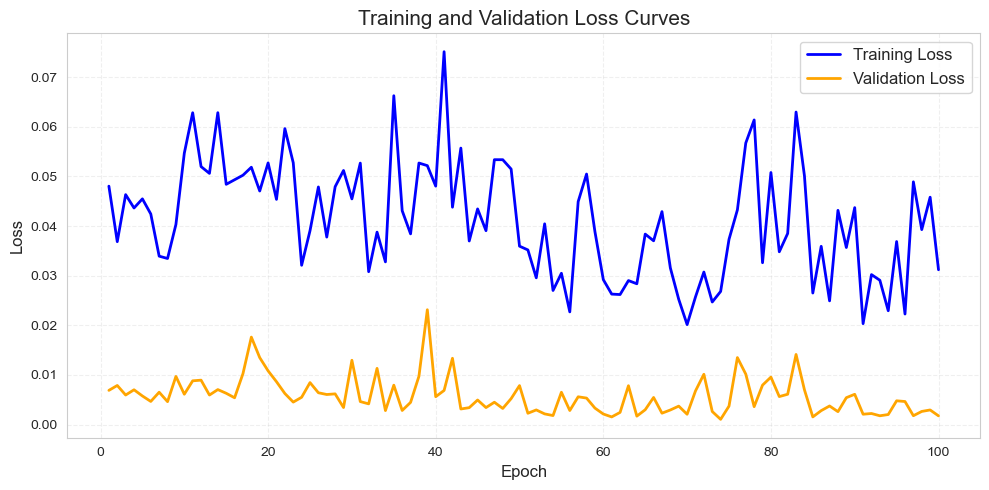

In [28]:
# 1. 绘制损失曲线（基于最终模型的训练过程）
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(final_train_losses)+1), final_train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, len(final_val_losses)+1), final_val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss Curves', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

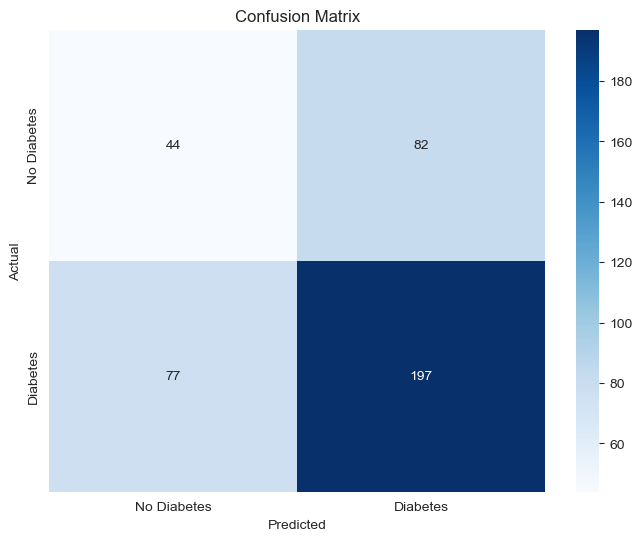

In [29]:
# 混淆矩阵热力图
cm = confusion_matrix(y_test, test_predicted.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


特征重要性排序（从高到低）:
1. randomGlucose_2023: 0.2671
2. plateletCount_2023: 0.2528
3. postprandialGlucose_2024: 0.2520
4. totalCholesterol_2022: 0.2488
5. randomGlucose_2022: 0.2469
6. plateletCount_2024: 0.2457
7. plateletCount_2022: 0.2323
8. diastolicBP_2024: 0.2304
9. triglycerides_2023: 0.2274
10. restingHeartRate_2022: 0.2270
11. hba1c_2022: 0.2254
12. totalHDLRatio_2023: 0.2227
13. totalCholesterol_2024: 0.2221
14. restingHeartRate_2023: 0.2214
15. FamilyHistory: 0.2182
16. restingHeartRate_2024: 0.2165
17. hemoglobin_2022: 0.2161
18. hemoglobin_2023: 0.2150
19. hemoglobin_2024: 0.2149
20. randomGlucose_2024: 0.2148
21. fastingGlucose_2023: 0.2136
22. hba1c_2024: 0.2130
23. hba1c_2023: 0.2125
24. lifestyleScore_2022: 0.2103
25. diastolicBP_2023: 0.2100
26. whiteBloodCell_2024: 0.2100
27. whiteBloodCell_2023: 0.2075
28. postprandialGlucose_2023: 0.2068
29. totalHDLRatio_2024: 0.2058
30. lifestyleScore_2024: 0.2037
31. triglycerides_2022: 0.2031
32. creatinine_2023: 0.2003
33. creatinine

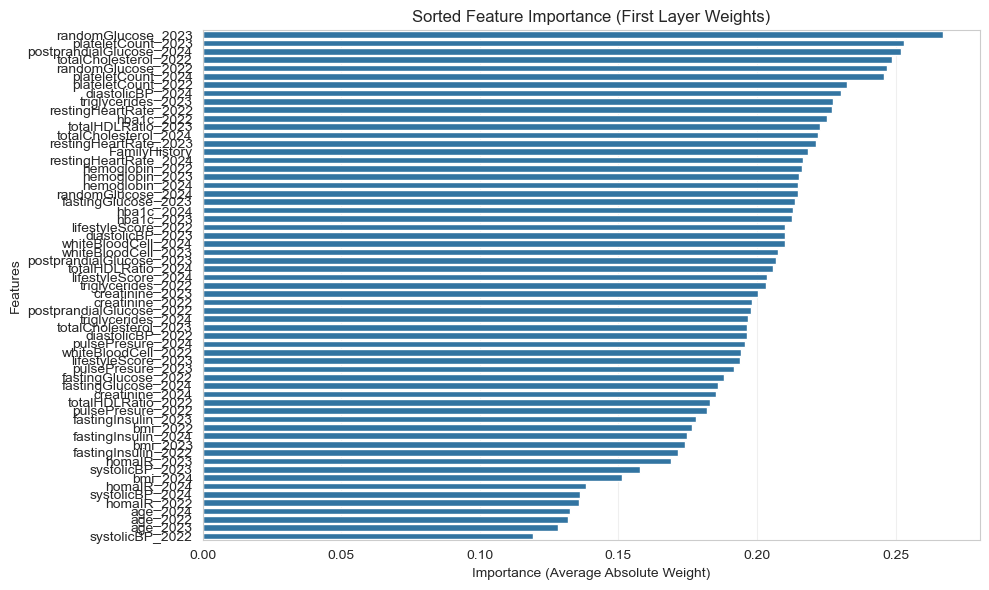

In [30]:
# 3. 特征重要性分析（基于最优模型的第一层权重）
first_layer_weights = model_final.net[0].weight.detach().numpy()
feature_importance = np.mean(np.abs(first_layer_weights), axis=0)
features = X.columns

# 按重要性排序
indices = np.argsort(feature_importance)[::-1]  # 获取从大到小的索引
sorted_importance = feature_importance[indices]
sorted_features = features[indices]

# 打印特征重要性
print("\n特征重要性排序（从高到低）:")
for i, (feature, importance) in enumerate(zip(sorted_features, sorted_importance)):
    print(f"{i+1}. {feature}: {importance:.4f}")

# 绘制排序后的特征重要性条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.xlabel('Importance (Average Absolute Weight)')
plt.ylabel('Features')
plt.title('Sorted Feature Importance (First Layer Weights)')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()  # 确保标签完整显示
plt.show()